# kaggle

In [ ]:
# Google drive setup
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
import json
token = {"username":"xuwenqiu","key":"e15af4db4983e1b2aa75c8e658bbbe9e"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -qo '/content/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/gtzan-dataset-music-genre-classification.zip'

100% 1.21G/1.21G [00:08<00:00, 148MB/s]
100% 1.21G/1.21G [00:08<00:00, 151MB/s]


In [ ]:
import numpy as np
import pandas as pd

import random

import librosa

import os

import torch
from torch import optim
from torch import nn

import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Dataset

In [ ]:
class MusicDS(Dataset):
    # Prepare the exact file path of the audio files and the corresponding labels
    def __init__(self, path):
        labels = os.listdir(path)
        self.idx_to_labels = {k:v for k,v in enumerate(labels)}
        self.labels_to_idx = {v:k for k,v in enumerate(labels)}
        
        songs_lists = [os.listdir(path + l) for l in labels]
        songs_lists = [list(map(list, zip([path + labels[i] + '/' for a in range(len(sl))],sl))) for i,sl in enumerate(songs_lists)]
        labels = np.array([[s[0].split('/')[-2] for s in l] for l in songs_lists])
        labels = labels.reshape(labels.shape[0] * labels.shape[1])
        
        songs_lists = np.array([[s[0] + s[1] for s in l] for l in songs_lists])
        songs_lists = songs_lists.reshape(songs_lists.shape[0] * songs_lists.shape[1])
        self.labels, self.songs_lists = shuffle(labels, songs_lists)
    
    def __len__(self):
        return len(self.songs_lists)

    # Transform the numpy array to mel spectrum
    def pre_process_audio_mel_t(self, audio, sample_rate=16000):
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64)
        mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40) / 40
        return mel_db.T
        
    def random_mask(self, data, rate_start=0.1, rate_seq=0.2):
        new_data = data.copy()
        mean = new_data.mean()
        prev_zero = False
        for i in range(new_data.shape[0]):
            if random.random() < rate_start or (
                prev_zero and random.random() < rate_seq
            ):
                prev_zero = True
                new_data[i, :] = mean
            else:
                prev_zero = False

        return new_data

    def random_multiply(self, data):
        new_data = data.copy()
        return new_data * (0.9 + random.random() / 5.)
    
    def __getitem__(self, idx):
        song_path = self.songs_lists[idx]

        try:
            # Load the .wav file into a numpy array
            fff, sr = librosa.load(song_path)
        except:
            idx += 1
            song_path = self.songs_lists[idx]
            fff, sr = librosa.load(song_path)

        # Transform the numpy array into the mel spectrum
        # the shape should be similar to `(1293, 64)`
        melspectrum = self.pre_process_audio_mel_t(fff, sr)[:1250]
        
        # Data augmentation
        # random mask the mel spectrum
        x = self.random_mask(melspectrum)
        # add random noise
        x = self.random_multiply(x)

        # get the corresponding label index
        y = self.labels_to_idx[self.labels[idx]]

        return x, y

In [ ]:
path = '/content/Data/genres_original/'
music_ds = MusicDS(path)

In [ ]:
# 这是一个 经过数据增强处理的 二维 mel spectrum
music_ds[100][0].shape

(1250, 64)

In [ ]:
test_size = int(len(music_ds) * 0.2)
train_size = int(len(music_ds) - test_size)

train_dataset, test_dataset = torch.utils.data.random_split(music_ds, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Network-original

In [ ]:
class Net(nn.Module):
    def __init__(self, n_input=2, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Network-COLA

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, drop_connect_rate=0.1):
        super(Encoder, self).__init__()

        self.cnn1 = torch.nn.Conv2d(1, 3, kernel_size=3)
        self.efficientnet = EfficientNet.from_name(
            "efficientnet-b0", include_top=False, drop_connect_rate=drop_connect_rate
        )

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.cnn1(x)
        x = self.efficientnet(x)

        y = x.squeeze(3).squeeze(2)

        return y

In [ ]:
def freeze(layer):
    for child in layer.children():
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
class AudioClassifier(torch.nn.Module):
    def __init__(self, classes=10, p=0.1):
        super().__init__()
        # self.save_hyperparameters()

        self.p = p

        self.do = torch.nn.Dropout(p=self.p)

        self.encoder = Encoder(drop_connect_rate=self.p)
        
        # freeze the parameters of the encoder layer
        freeze(self.encoder)

        self.g = torch.nn.Linear(1280, 1024)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape=1024)

        self.fc1 = torch.nn.Linear(1024, 512)
        self.fy = torch.nn.Linear(512, classes)

    def forward(self, x):
        #print(x.shape)
        x = self.do(self.encoder(x))
        #print(x.shape)

        x = self.do(self.g(x))
        x = self.do(torch.tanh(self.layer_norm(x)))

        x = F.relu(self.do(self.fc1(x)))
        y_hat = self.fy(x)

        return y_hat

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = AudioClassifier().to(device)
temp = torch.load('/content/epoch=80-step=12311.ckpt') 
net.load_state_dict(temp['state_dict'], strict=False)

RuntimeError: ignored

# Training


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train(model, epoch):

    losses = []
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):

        data = data.to(device)
        target = target.to(device)

        output = model(data).to(device)

        loss = nn.CrossEntropyLoss()(output.squeeze(), target)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

In [ ]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0

    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data).to(device)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
n_epoch = 60

losses = []
accuracies = []

for epoch in range(1, n_epoch + 1):
    loss = train(net, epoch)
    losses.append(sum(loss) / len(loss))

    accuracy = test(net, epoch)
    accuracies.append(accuracy)
    print("validation accuracy:", accuracy)
    scheduler.step()

In [ ]:
print(loss)

[-4810.18896484375, -5415.7587890625, -5991.45849609375, -6573.8076171875, -7255.6689453125, -7969.556640625, -8697.8125, -9500.5498046875, -10278.1728515625, -11154.119140625, -12068.97265625, -13036.6552734375, -14122.6455078125, -15198.2529296875, -16191.025390625, -17431.650390625, -18448.052734375, -19853.86328125, -21068.638671875, -22291.828125, -23884.166015625, -25169.0546875, -26549.11328125, -28329.650390625, -29899.80078125]


# Analysis

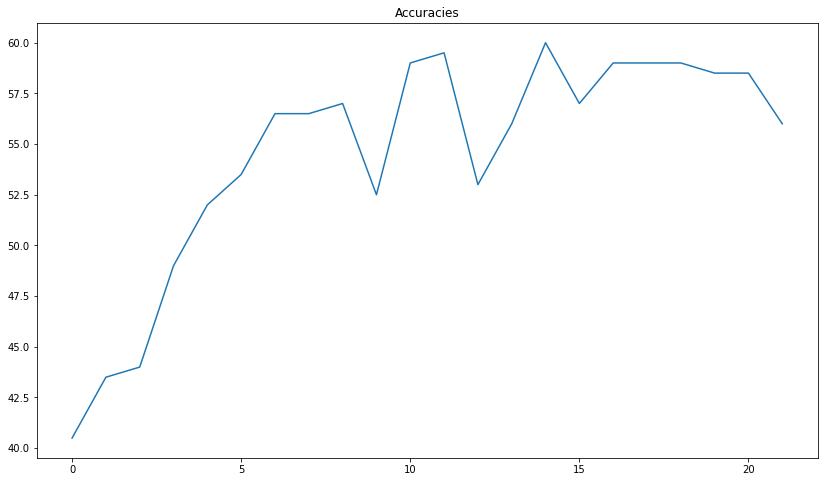

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(accuracies)

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(losses)